In [24]:
!pip install torchmetrics mlxtend

In [4]:
# Fully Updated and Detailed Version of Assignment 4 - CNN on FashionMNIST

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import random
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path
from sklearn.metrics import classification_report

In [5]:
# 2. Image Transformations
transform_ops = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
# 3. Download and Prepare Dataset
train_dataset = FashionMNIST(root="data", train=True, download=True, transform=transform_ops)
test_dataset = FashionMNIST(root="data", train=False, download=True, transform=transform_ops)

In [7]:
# 4. Class Names
class_names = train_dataset.classes

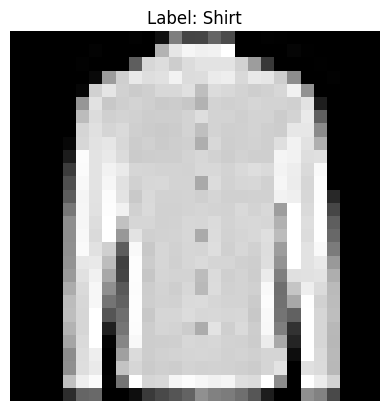

In [8]:
# 5. Display a Sample Image
rand_idx = torch.randint(0, len(train_dataset), size=(1,)).item()
sample_img, sample_lbl = train_dataset[rand_idx]
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[sample_lbl]}")
plt.axis("off")
plt.show()

In [9]:
# 6. Create Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# 7. CNN Model Definition
class FashionCNN(nn.Module):
    def __init__(self, in_channels: int, hidden_dim: int, num_classes: int):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(hidden_dim * 7 * 7, num_classes)
        )

    def forward(self, x):
        return self.conv_net(x)

In [12]:
hardware_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation will run on: {hardware_device}")

Computation will run on: cpu


In [13]:
# 8. Model Instantiation
cnn_model = FashionCNN(in_channels=1, hidden_dim=16, num_classes=len(class_names)).to(hardware_device)


In [14]:
# 9. Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [15]:

# 10. Accuracy Calculation Function
def compute_accuracy(preds, labels):
    predicted_labels = torch.argmax(preds, dim=1)
    return (predicted_labels == labels).sum().item() / len(labels)

In [16]:
# 11. Training and Evaluation Loop
num_epochs = 6
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for ep in range(num_epochs):
    cnn_model.train()
    total_train_loss, correct_train = 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(hardware_device), lbls.to(hardware_device)

        preds = cnn_model(imgs)
        loss = loss_fn(preds, lbls)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += compute_accuracy(preds, lbls)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(correct_train / len(train_loader))

    cnn_model.eval()
    total_test_loss, correct_test = 0, 0
    with torch.inference_mode():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(hardware_device), lbls.to(hardware_device)
            preds = cnn_model(imgs)
            total_test_loss += loss_fn(preds, lbls).item()
            correct_test += compute_accuracy(preds, lbls)

    test_losses.append(total_test_loss / len(test_loader))
    test_accuracies.append(correct_test / len(test_loader))

    print(f"Epoch {ep+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% | ",
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]*100:.2f}%")


Epoch 1: Train Loss: 0.4799, Train Acc: 82.48% |  Test Loss: 0.3609, Test Acc: 86.98%
Epoch 2: Train Loss: 0.3103, Train Acc: 88.75% |  Test Loss: 0.3047, Test Acc: 89.15%
Epoch 3: Train Loss: 0.2691, Train Acc: 90.33% |  Test Loss: 0.2863, Test Acc: 89.12%
Epoch 4: Train Loss: 0.2414, Train Acc: 91.34% |  Test Loss: 0.2818, Test Acc: 89.84%
Epoch 5: Train Loss: 0.2250, Train Acc: 91.96% |  Test Loss: 0.2485, Test Acc: 91.01%
Epoch 6: Train Loss: 0.2130, Train Acc: 92.33% |  Test Loss: 0.2377, Test Acc: 91.33%


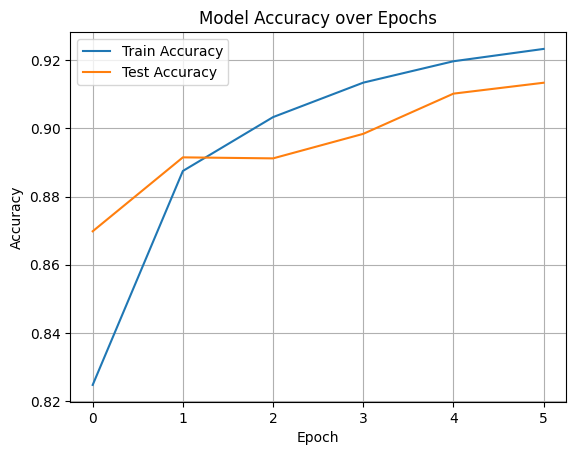

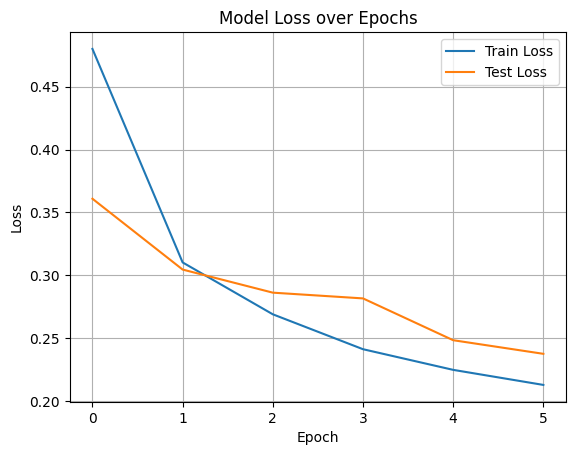

In [17]:
# 12. Plot Accuracy and Loss over Epochs
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Model Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Model Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

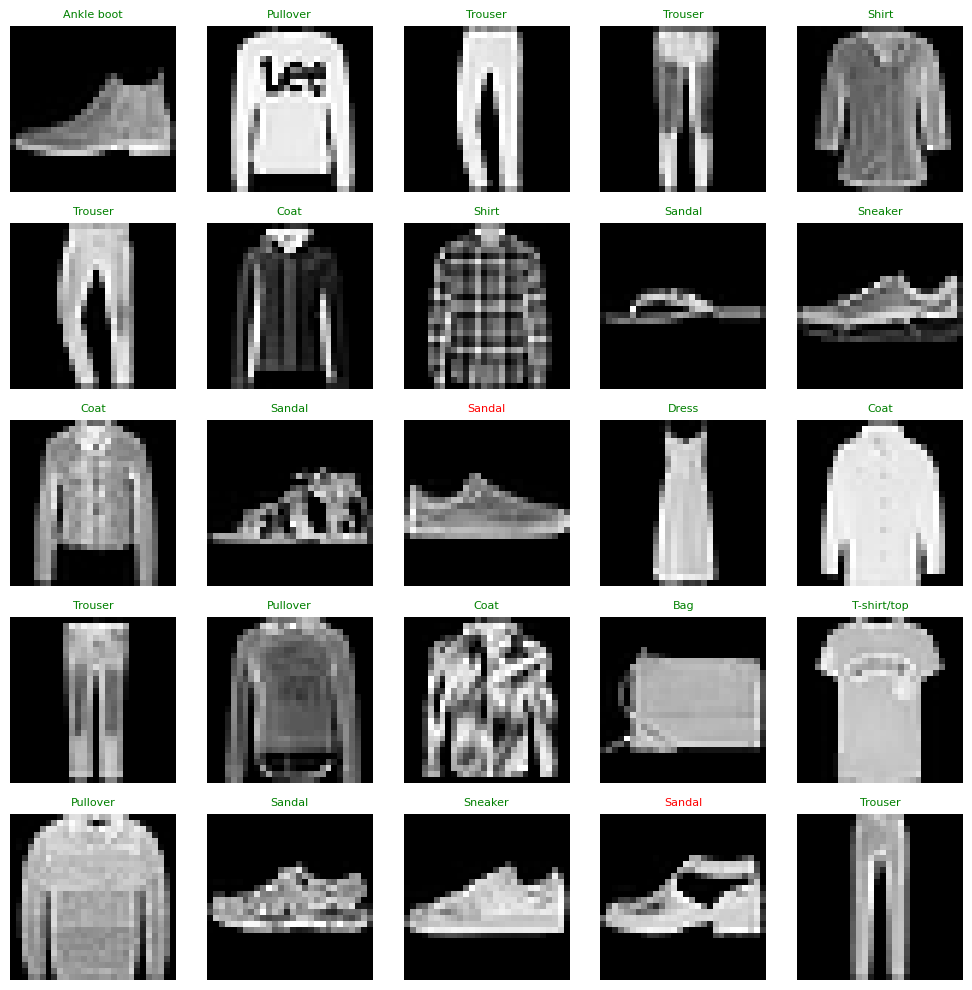

In [18]:
# 13. Prediction Visualization - 25 Samples
fig = plt.figure(figsize=(10, 10))
cnn_model.eval()
for i in range(25):
    img, lbl = test_dataset[i]
    with torch.inference_mode():
        pred = cnn_model(img.unsqueeze(0).to(hardware_device))
    pred_label = torch.argmax(pred, dim=1).item()
    color = "green" if pred_label == lbl else "red"
    plt.subplot(5, 5, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"{class_names[pred_label]}", color=color, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()

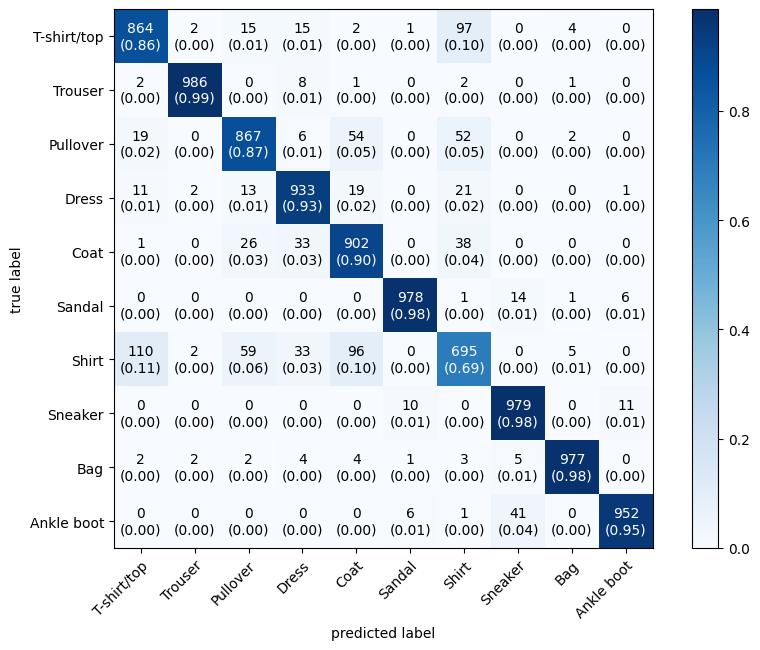

In [19]:
# 14. Confusion Matrix
all_preds = []
all_labels = []
with torch.inference_mode():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(hardware_device), lbls.to(hardware_device)
        preds = cnn_model(imgs)
        pred_labels = torch.argmax(preds, dim=1)
        all_preds.append(pred_labels.cpu())
        all_labels.append(lbls.cpu())

flat_preds = torch.cat(all_preds)
flat_labels = torch.cat(all_labels)

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=flat_preds, target=flat_labels)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True
)
plt.show()

In [20]:
# 15. Classification Report
print("\nClassification Report:\n")
print(classification_report(flat_labels, flat_preds, target_names=class_names))



Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.87      0.87      1000
       Dress       0.90      0.93      0.92      1000
        Coat       0.84      0.90      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.69      0.73      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [21]:
# 16. Save and Reload the Model
save_dir = Path("saved_models")
save_dir.mkdir(parents=True, exist_ok=True)
model_weights_path = save_dir / "cnn_fashion_weights.pth"
model_full_path = save_dir / "cnn_fashion_full_model.pth"

In [22]:
# Save state_dict and full model
torch.save(cnn_model.state_dict(), model_weights_path)
torch.save(cnn_model, model_full_path)
print(f"Model saved at: {model_weights_path} and {model_full_path}")

Model saved at: saved_models/cnn_fashion_weights.pth and saved_models/cnn_fashion_full_model.pth


In [23]:
# Reload and Evaluate
reloaded_model = FashionCNN(in_channels=1, hidden_dim=16, num_classes=len(class_names))
reloaded_model.load_state_dict(torch.load(model_weights_path))
reloaded_model.to(hardware_device)
reloaded_model.eval()

print("\nReloaded model evaluation done. Model successfully restored.")


Reloaded model evaluation done. Model successfully restored.
